In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada VGG16 para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from keras import regularizers
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.inception_v3.InceptionV3(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/Database3.zip #comando linux

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Database3/Train/nv/ISIC_0026937.jpg  
  inflating: Database3/Train/nv/ISIC_0026939.jpg  
  inflating: Database3/Train/nv/ISIC_0026942.jpg  
  inflating: Database3/Train/nv/ISIC_0026943.jpg  
  inflating: Database3/Train/nv/ISIC_0026945.jpg  
  inflating: Database3/Train/nv/ISIC_0026946.jpg  
  inflating: Database3/Train/nv/ISIC_0026949.jpg  
  inflating: Database3/Train/nv/ISIC_0026971.jpg  
  inflating: Database3/Train/nv/ISIC_0026973.jpg  
  inflating: Database3/Train/nv/ISIC_0026974.jpg  
  inflating: Database3/Train/nv/ISIC_0026977.jpg  
  inflating: Database3/Train/nv/ISIC_0026979.jpg  
  inflating: Database3/Train/nv/ISIC_0026980.jpg  
  inflating: Database3/Train/nv/ISIC_0026982.jpg  
  inflating: Database3/Train/nv/ISIC_0026983.jpg  
  inflating: Database3/Train/nv/ISIC_0026985.jpg  
  inflating: Database3/Train/nv/ISIC_0026994.jpg  
  inflating: Database3/Train/nv/ISIC_0026997.jpg  
  inflating: Database

Ajustando los datos de la BD


In [ ]:
train_dataset = image_dataset_from_directory(
    'Database3/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

validation_dataset = image_dataset_from_directory(
    'Database3/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Database3/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#train_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(train_dataset_n))

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#validation_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(validation_dataset_n))

#normalization_layer = tf.keras.layers.Rescaling(1./255)
#test_dataset_n = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(test_dataset_n))


Found 5284 files belonging to 4 classes.
Found 2263 files belonging to 4 classes.
Found 1884 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [ ]:
#@title La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(385, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 180, 180, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 180, 180, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048   21802784  
                             )                                   
                                                             

Fijar los hiperparámetros y entrenar la red

In [ ]:
from keras.callbacks import EarlyStopping
checkpoint_filepath = 'model20-12-2020_dp03031024.h5' #'/content'
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        #filepath=checkpoint_filepath,
        filepath='model20-12-2020_dp03031024.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1,
        save_best_only=True)
]

history = model.fit(
    train_dataset,
    epochs=1000,  #30
    validation_data=validation_dataset,
    callbacks=callbacks_list)

Epoch 1/1000
166/166 [==============================] - ETA: 0s - loss: 10.1184 - accuracy: 0.6387
Epoch 1: val_accuracy improved from -inf to 0.74017, saving model to model20-12-2020_dp03031024.h5
166/166 [==============================] - 35s 101ms/step - loss: 10.1184 - accuracy: 0.6387 - val_loss: 3.7624 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 2/1000
165/166 [============================>.] - ETA: 0s - loss: 2.1951 - accuracy: 0.7231
Epoch 2: val_accuracy did not improve from 0.74017
166/166 [==============================] - 13s 75ms/step - loss: 2.1950 - accuracy: 0.7227 - val_loss: 1.7369 - val_accuracy: 0.6178 - lr: 0.0010
Epoch 3/1000
165/166 [============================>.] - ETA: 0s - loss: 1.2803 - accuracy: 0.7318
Epoch 3: val_accuracy did not improve from 0.74017
166/166 [==============================] - 13s 75ms/step - loss: 1.2808 - accuracy: 0.7316 - val_loss: 1.2775 - val_accuracy: 0.6567 - lr: 0.0010
Epoch 4/1000
165/166 [============================>.] - ETA: 0s 

Visualizando la pérdida y el accuracy durante el entrenamiento


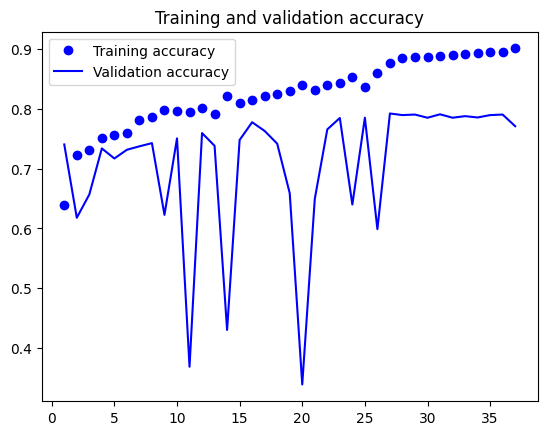

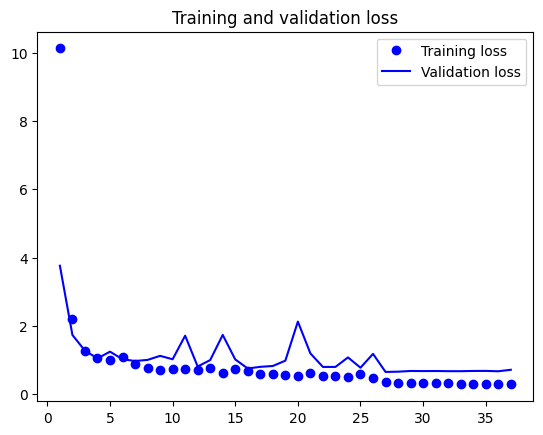

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
print("--------------------------Test Results------------------------")
test_scores = model.evaluate(test_dataset, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

--------------------------Test Results------------------------
59/59 - 4s - loss: 0.7051 - accuracy: 0.7675 - 4s/epoch - 76ms/step
Test Loss: 0.7051206827163696
Test Accuracy: 0.7675158977508545


### Matriz de confusión y métricas relevantes



In [ ]:
import numpy as np

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 1s 1s/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[ 254   11   12   12]
 [  28  498   54   36]
 [  11   41  523   49]
 [  18   97  233 3407]]


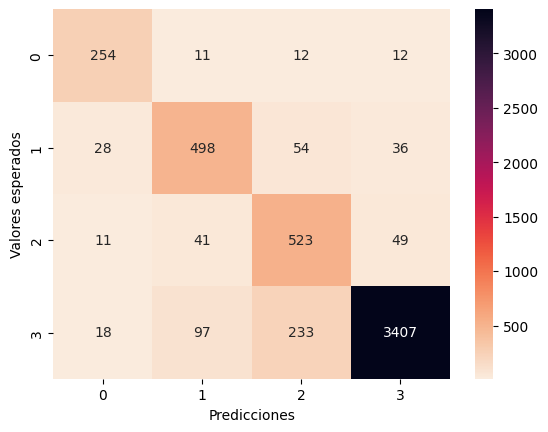

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       289
           1       0.77      0.81      0.79       616
           2       0.64      0.84      0.72       624
           3       0.97      0.91      0.94      3755

    accuracy                           0.89      5284
   macro avg       0.80      0.86      0.82      5284
weighted avg       0.90      0.89      0.89      5284



In [ ]:
#predicciones_test = model.predict(images_test)
import matplotlib.pyplot as plt
import seaborn as sns

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
#fig, ax = plot_confusion_matrix(conf_mat = cf)
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 28ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[  73   21   13   16]
 [  16  145   50   53]
 [  10   36  146   75]
 [  26   73  130 1380]]


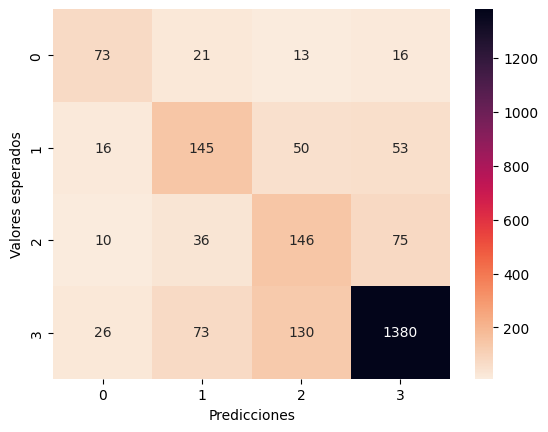

              precision    recall  f1-score   support

           0       0.58      0.59      0.59       123
           1       0.53      0.55      0.54       264
           2       0.43      0.55      0.48       267
           3       0.91      0.86      0.88      1609

    accuracy                           0.77      2263
   macro avg       0.61      0.64      0.62      2263
weighted avg       0.79      0.77      0.78      2263



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
#fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 31ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

[[  57   15   14   16]
 [  13  120   46   40]
 [   7   29  125   61]
 [  19   65  113 1144]]


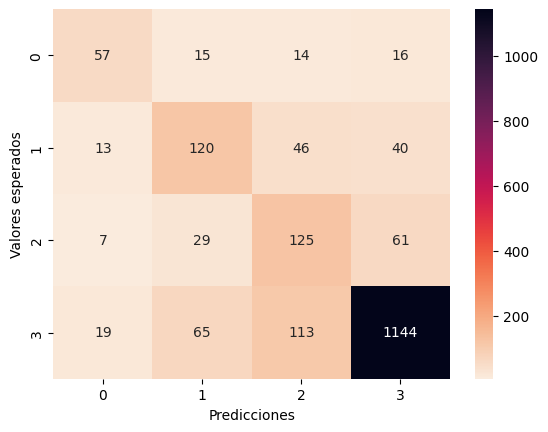

              precision    recall  f1-score   support

           0       0.59      0.56      0.58       102
           1       0.52      0.55      0.54       219
           2       0.42      0.56      0.48       222
           3       0.91      0.85      0.88      1341

    accuracy                           0.77      1884
   macro avg       0.61      0.63      0.62      1884
weighted avg       0.79      0.77      0.78      1884



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')


## It canbe used in any platform
#fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

### Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow as tf
import pathlib

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
#tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir = pathlib.Path(".")
tflite_model_file = tflite_models_dir/"model_InceptionV3.tflite"
tflite_model_file.write_bytes(tflite_model)

94100180